exercises
Select a dataset with a continuous target variable.

Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [1]:
import pandas as pd
import numpy as np
import prepare_zillow
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

In [2]:
df= prepare_zillow.clean_zillow()
df=df.drop(columns=["transactiondate","airconditioning","heating","architectural_style","property_type", "construction_type"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   parcel_id                         116 non-null    int64  
 1   bathroom_count                    116 non-null    float64
 2   bedroom_count                     116 non-null    float64
 3   square_feet                       116 non-null    float64
 4   fips                              116 non-null    float64
 5   car_size_garage                   116 non-null    float64
 6   latitude                          116 non-null    float64
 7   longitude                         116 non-null    float64
 8   pool_count                        116 non-null    float64
 9   propertycountylandusecode         116 non-null    int64  
 10  rawcensustractandblock            116 non-null    float64
 11  regionidcity                      116 non-null    float64
 12  regionid

In [3]:
def split(df, stratify_by=""):
    '''
    take in a DataFrame and return train, validate, and test DataFrames.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123)
    return train, validate, test

In [4]:
# Split the data
train, validate, test = split(df, stratify_by="tax_value_dollar_count")
train.shape, validate.shape, test.shape

((64, 24), (28, 24), (24, 24))

In [5]:
target = "tax_value_dollar_count"

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train.drop(columns=[target])
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate.drop(columns=[target])
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test.drop(columns=[target])
y_test = test[target]

X_train.head()

,parcel_id,bathroom_count,bedroom_count,square_feet,fips,car_size_garage,latitude,longitude,pool_count,propertycountylandusecode,...,regionidzip,room_count,yearbuilt,numberofstories,structure_tax_value_dollar_count,assessmentyear,land_tax_value_dollar_count,taxamount,censustractandblock,logerror
110,14657459,1.0,1.0,988.0,6059.0,0.0,33609900.0,-117751000.0,1.0,34,...,96963.0,4.0,1975.0,1.0,92342.0,2016.0,40508.0,1311.50,6.059063e+13,-0.028501
61,14603899,1.5,2.0,1200.0,6059.0,2.0,33873600.0,-117892000.0,1.0,34,...,97039.0,5.0,1979.0,2.0,119515.0,2016.0,54488.0,2151.46,6.059012e+13,-0.032215
41,14306854,3.0,4.0,2539.0,6059.0,2.0,33683349.0,-117784221.0,1.0,122,...,96941.0,8.0,1978.0,2.0,175466.0,2016.0,777225.0,9958.02,6.059053e+13,-0.005310
45,14645791,1.5,2.0,928.0,6059.0,1.0,33718400.0,-117887000.0,1.0,34,...,97004.0,4.0,1964.0,2.0,43728.0,2016.0,146272.0,2461.34,6.059074e+13,0.053269
66,14606438,1.5,2.0,1190.0,6059.0,1.0,33636000.0,-117679000.0,1.0,34,...,96962.0,4.0,1979.0,2.0,78534.0,2016.0,278466.0,3699.08,6.059032e+13,0.031663


In [6]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict tax_value_dollar_count_pred_mean
tax_value_dollar_count_pred_mean = y_train.tax_value_dollar_count.mean()
y_train['tax_value_dollar_count_pred_mean'] = tax_value_dollar_count_pred_mean
y_validate['tax_value_dollar_count_pred_mean'] = tax_value_dollar_count_pred_mean

# 2. compute tax_value_dollar_count_pred_median
tax_value_dollar_count_pred_median = y_train.tax_value_dollar_count.median()
y_train['tax_value_dollar_count_pred_median'] = tax_value_dollar_count_pred_median
y_validate['tax_value_dollar_count_pred_median'] = tax_value_dollar_count_pred_median

# 3. RMSE of tax_value_dollar_count_pred_mean
rmse_train = mean_squared_error(y_train.tax_value_dollar_count, y_train.tax_value_dollar_count_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value_dollar_count, y_validate.tax_value_dollar_count_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tax_value_dollar_count_pred_median
rmse_train = mean_squared_error(y_train.tax_value_dollar_count, y_train.tax_value_dollar_count_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value_dollar_count, y_validate.tax_value_dollar_count_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  161830.99 
Validate/Out-of-Sample:  159780.76
RMSE using Median
Train/In-Sample:  164830.95 
Validate/Out-of-Sample:  166334.16


In [7]:
from sklearn.metrics import explained_variance_score

In [8]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value_dollar_count, y_validate.tax_value_dollar_count_pred_mean)}])

In [9]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,166334.162904,4.440892e-16


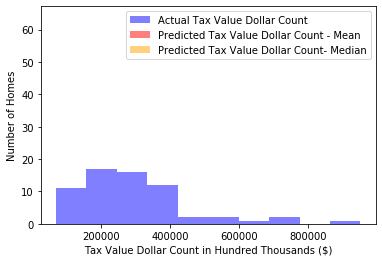

In [10]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value_dollar_count, color='blue', alpha=.5, label="Actual Tax Value Dollar Count")
plt.hist(y_train.tax_value_dollar_count_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Tax Value Dollar Count - Mean")
plt.hist(y_train.tax_value_dollar_count_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Tax Value Dollar Count- Median")
plt.xlabel("Tax Value Dollar Count in Hundred Thousands ($)")
plt.ylabel("Number of Homes")
plt.legend()
plt.show()

In [11]:
y_train.head()

,tax_value_dollar_count,tax_value_dollar_count_pred_mean,tax_value_dollar_count_pred_median
110,132850.0,287785.015625,256480.5
61,174003.0,287785.015625,256480.5
41,952691.0,287785.015625,256480.5
45,190000.0,287785.015625,256480.5
66,357000.0,287785.015625,256480.5


In [12]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train, y_train.tax_value_dollar_count)

# predict train
# 
# use the thing!
# 
y_train['tax_value_dollar_count_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value_dollar_count, y_train.tax_value_dollar_count_pred_lm) ** (1/2)

# predict validate
y_validate['tax_value_dollar_count_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value_dollar_count, y_validate.tax_value_dollar_count_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  1.9180637352264513e-10 
Validation/Out-of-Sample:  2.612550811018197e-10


In [13]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value_dollar_count, y_validate.tax_value_dollar_count_pred_lm)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,1.663342e+05,4.440892e-16
1,OLS Regressor,2.612551e-10,1.000000e+00


In [14]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value_dollar_count)

# predict train
y_train['tax_value_dollar_count_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value_dollar_count, y_train.tax_value_dollar_count_lars) ** (1/2)

# predict validate
y_validate['tax_value_dollar_count_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value_dollar_count, y_validate.tax_value_dollar_count_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  10.130939049100576 
Validation/Out-of-Sample:  10.575993790819323


In [15]:
metric_df = metric_df.append({
    'model': 'Lasso alpha 1', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value_dollar_count, y_validate.tax_value_dollar_count_lars)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,1.663342e+05,4.440892e-16
1,OLS Regressor,2.612551e-10,1.000000e+00
2,Lasso alpha 1,1.057599e+01,1.000000e+00


In [17]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value_dollar_count)

# predict train
y_train['tax_value_dollar_count_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value_dollar_count, y_train.tax_value_dollar_count_glm) ** (1/2)

# predict validate
y_validate['tax_value_dollar_count_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.tax_value_dollar_count, y_train.tax_value_dollar_count_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  161830.99124882687 
Validation/Out-of-Sample:  161830.99124882687


In [18]:
metric_df = metric_df.append({
    'model': 'GLS (Poisson)', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value_dollar_count, y_validate.tax_value_dollar_count_glm)}, ignore_index=True)

In [19]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,1.663342e+05,4.440892e-16
1,OLS Regressor,2.612551e-10,1.000000e+00
2,Lasso alpha 1,1.057599e+01,1.000000e+00
3,GLS (Poisson),1.618310e+05,4.440892e-16
